Number of Observations/datapoints in each dimension 12070
Train data X shape:  (9654, 1, 1)
Train data Y shape:  (9654, 1)
Test data X shape:  (2412, 1, 1)
Test data Y shape:  (2412, 1)
*****************************************
Learning with DyBM model RNNGaussian
*****************************************
learning with delay = 3
Currently writing to file: RMSE_DyBM_10delay_3.txt
train error: 0.00770
test error: 0.03210 
delay = 3.000000 decay = [0.5] curr_mean_error = 0.032097
train error: 0.00725
test error: 0.03169 
delay = 3.000000 decay = [0.5] curr_mean_error = 0.031894
train error: 0.00713
test error: 0.03149 
delay = 3.000000 decay = [0.5] curr_mean_error = 0.031760
train error: 0.00705
test error: 0.03140 
delay = 3.000000 decay = [0.5] curr_mean_error = 0.031669
train error: 0.00700
test error: 0.03134 
delay = 3.000000 decay = [0.5] curr_mean_error = 0.031603
Mean train error with DyBM: 0.00723 RMSE
Mean test error with DyBM: 0.03160 RMSE
Per epoch time to learn: 4.46111 sec.

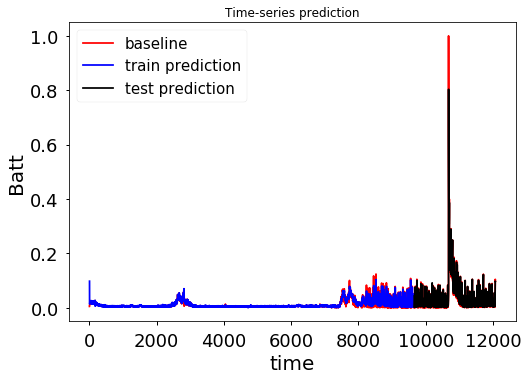

<Figure size 288x576 with 0 Axes>

********************
Learning with LSTM
********************
Epoch 1/5
 - 32s - loss: 5.1659e-05
Epoch 2/5
 - 33s - loss: 3.5551e-05
Epoch 3/5
 - 36s - loss: 2.9882e-05
Epoch 4/5
 - 39s - loss: 2.7790e-05
Epoch 5/5
 - 35s - loss: 2.6377e-05
Mean Train Score LSTM: 0.00523 RMSE
Mean Test Score LSTM: 0.02485 RMSE
Per epoch time to learn: 176.33487 sec.
Currently writing to file: RMSE_LSTM_10no_delay_epc5.xml
******Simple-RNN*******************


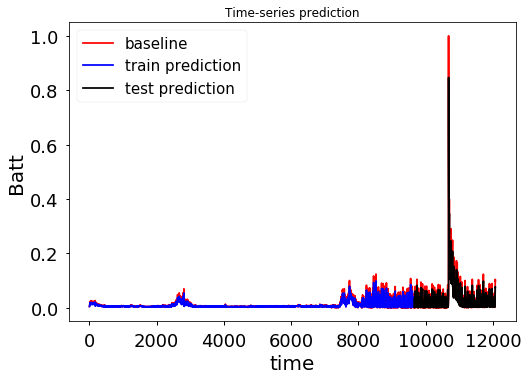

<Figure size 288x576 with 0 Axes>

************************
Learning with SimpleRNN
************************
Epoch 1/5
 - 18s - loss: 2.7424e-05
Epoch 2/5
 - 15s - loss: 2.5870e-05
Epoch 3/5
 - 21s - loss: 2.5309e-05
Epoch 4/5
 - 15s - loss: 2.5611e-05
Epoch 5/5
 - 16s - loss: 2.5054e-05
Mean Train Score SimpleRNN: 0.00539 RMSE
Mean Test Score SimpleRNN: 0.02799 RMSE
Per epoch time to learn: 86.50874 sec.
Currently writing to file: RMSE_SimpleRNN_10no_delay_epc5.xml
******Simple-RNN*******************


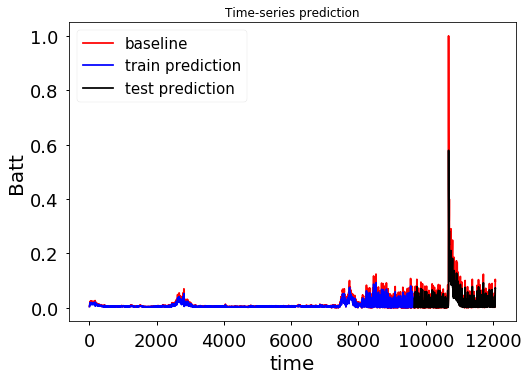

<Figure size 288x576 with 0 Axes>

In [17]:

import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
import time
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
import os

from pydybm.time_series.dybm import LinearDyBM
from pydybm.time_series.rnn_gaussian_dybm import RNNGaussianDyBM, GaussianDyBM
from pydybm.base.sgd import RMSProp
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.metrics import mean_squared_error

#dir_path = os.path.dirname(os.path.realpath(__file__))
#head = os.path.split(dir_path)[0]
#parent = os.path.dirname(head)
# load the dataset
dataframe = pandas.read_csv("/home/dhruv/Downloads/BH11D_CF_Algo (labelled) - BH11D_CF_Algo (labelled).csv",
                        usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')


def MSE(y_true, y_pred):
    """
    Mean squared error of a sequence of predicted vectors

    y_true : array, shape(L, N)
    y_pred : array, shape(L, N)

    mean of (dy_1^2 + ... + dy_N^2 ) over L pairs of vectors
    (y_true[i], y_pred[i])
    """
    MSE_each_coordinate = mean_squared_error(y_true, y_pred,
                                             multioutput="raw_values")
    return np.sum(MSE_each_coordinate)


def RMSE(y_true, y_pred):
    """
    Root mean squared error of a sequence of predicted vectors

    y_true : array, shape(L, N)
    y_pred : array, shape(L, N)

    squared root of the mean of (dy_1^2 + ... + dy_N^2 ) over L pairs of
    vectors (y_true[i], y_pred[i])
    """
    return np.sqrt(MSE(y_true, y_pred))


# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)


def learn_KerasRNN(trainX, trainY, testX, testY, modelType):
    if modelType == "LSTM":
        print ('********************')
        print ('Learning with LSTM')
        print ('********************')
        saveResults = True
        # create and fit the LSTM network
        hidden_no = 10
        max_epochs = 5
        model = Sequential()
        model.add(LSTM(hidden_no, activation='tanh', input_shape=(None, 1)))
        model.add(Dense(input_dim=hidden_no, units=1,
                        activation='linear'))
        model.compile(loss='mse', optimizer='rmsprop')
        start_time = time.time()
        model.fit(trainX, trainY, epochs=max_epochs, shuffle=False,
                  batch_size=1, verbose=2)
        end_time = time.time() - start_time
        # Estimate model training performance
        trainScore = model.evaluate(trainX, trainY, verbose=0)
        trainScore = math.sqrt(trainScore)

        # trainScore = scaler.inverse_transform(numpy.array([[trainScore]]))
        print('Mean Train Score LSTM: %.5f RMSE' % (trainScore))

        # Estimate model test performance
        testScore = model.evaluate(testX, testY, verbose=0)
        testScore = math.sqrt(testScore)

        # testScore = scaler.inverse_transform(numpy.array([[testScore]]))
        print('Mean Test Score LSTM: %.5f RMSE' % (testScore))
        print ('Per epoch time to learn: %.5f sec.' % (end_time))

        if saveResults:
            filename = "RMSE_LSTM_" + str(hidden_no) + "no_delay" + "_epc" \
                       + str(max_epochs) + ".xml"
            out_file = open(filename, "wb")
            out_file.write('Decay' + '\t' + 'LSTM Train RMSE' + '\t'
                           + 'LSTM TestRMSE' + '\n')

            print ('Currently writing to file: %s' % (out_file.name))

            out_file.close()

    elif modelType == "SimpleRNN":
        print ('************************')
        print ('Learning with SimpleRNN')
        print ('************************')
        saveResults = True
        # create and fit the LSTM network
        hidden_no = 10
        max_epochs = 5
        model = Sequential()
        model.add(SimpleRNN(hidden_no,
                            activation='tanh',
                            input_shape=(None, 1)))
        model.add(Dense(input_dim=hidden_no, units=1,
                        activation='linear'))
        model.compile(loss='mse', optimizer='rmsprop')
        start_time = time.time()
        model.fit(trainX, trainY, epochs=max_epochs, shuffle=False,
                  batch_size=1, verbose=2)
        end_time = time.time() - start_time
        # Estimate model training performance
        trainScore = model.evaluate(trainX, trainY, verbose=0)
        trainScore = math.sqrt(trainScore)

        # trainScore = scaler.inverse_transform(numpy.array([[trainScore]]))
        print('Mean Train Score SimpleRNN: %.5f RMSE' % (trainScore))

        # Estimate model test performance
        testScore = model.evaluate(testX, testY, verbose=0)
        testScore = math.sqrt(testScore)

        # testScore = scaler.inverse_transform(numpy.array([[testScore]]))
        print('Mean Test Score SimpleRNN: %.5f RMSE' % (testScore))
        print ('Per epoch time to learn: %.5f sec.' % (end_time))
        if saveResults:
            filename = "RMSE_SimpleRNN_" + str(hidden_no) + "no_delay" \
                       + "_epc" + str(max_epochs) + ".xml"
            out_file = open(filename, "wb")
            out_file.write('Decay' + '\t' + 'SimpleRNN Train RMSE' + '\t'
                           + 'SimpleRNN TestRMSE' + '\n')

            print ('Currently writing to file: %s' % (out_file.name))

            out_file.close()

    # generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    plotFig = True
    print('******Simple-RNN*******************')
    if(plotFig):
        plotData(trainPredict, testPredict, dataset)


def plotData(trainPredict, testPredict, dataset):
    

    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] \
        = testPredict

    # plot baseline and predictions for a fixed dimension
    plt.title("Time-series prediction")
    # choose the dimension of data to plot
  
    plt.xlabel('time', fontsize=20)
    plt.ylabel('Batt', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.plot(dataset, color='r', label='baseline')
    plt.plot(trainPredictPlot, color='b', label='train prediction')
    plt.plot(testPredictPlot, color='k', label='test prediction')
    plt.legend(fontsize=15)
    plt.figure(figsize=plt.figaspect(2.))
    plt.savefig("iter.png")
    plt.show()
   

def learn_DyBM(trainX, trainY, testX, testY, DyBMmodel):

    plotFig = True
    RNN_dim = 10
    input_dim = 1
    max_epochs = 5
    saveResults = True
    SGD = RMSProp

    """
    Choose the DyBM model type: VAR (default), Gaussian, RNNGaussian

    Change accordinly for other DyBM models
    """
    print ('*****************************************')
    print ('Learning with DyBM model %s' % (DyBMmodel))
    print ('*****************************************')

    trainX = np.reshape(trainX, (trainX.shape[0], input_dim))
    testX = np.reshape(testX, (testX.shape[0], input_dim))

    # default config of decay change accordinly
    decay = [0.5]

    for delay in [3]:

        print "learning with delay =", delay

        if saveResults:
            filename = "RMSE_DyBM_" + \
                str(RNN_dim) + "delay_" + str(delay) + ".txt"
            out_file = open(filename, "wb")
            out_file.write('Decay' + '\t' + 'DyBM Train RMSE' + '\t'
                           + 'DyBMTestRMSE' + '\n')

            print ('Currently writing to file: %s' % (out_file.name))

        if DyBMmodel == "VAR":
            dybm = LinearDyBM(input_dim, delay=delay, decay_rates=[0.0])
            dybm.set_learning_rate(0.001)
            dybm.init_state

        elif DyBMmodel == "RNNGaussian":

            dybm = RNNGaussianDyBM(input_dim, input_dim, RNN_dim, 0.3,
                                   0.1, delay, decay_rates=decay, leak=1.0,
                                   SGD=SGD())

            dybm.set_learning_rate(0.001)
            dybm.init_state

        elif DyBMmodel == "Gaussian":
            dybm = GaussianDyBM(input_dim, delay=delay, decay_rates=decay)
            dybm.set_learning_rate(0.001)
            dybm.init_state

        errs = list()
        train_errs = list()
        for epochs in range(max_epochs):

            # training
            start_time = time.time()
            dybm.init_state()
            result = dybm.learn(trainX, get_result=True)
            end_time = time.time() - start_time
            train_rmse = RMSE(trainY, result["prediction"])
            print ('train error: %.5f' % (train_rmse))

            # testing
            # dybm.init_state()
            result2 = dybm.learn(testX, get_result=True)
            test_rmse = RMSE(testY, result2["prediction"])

            print ('test error: %.5f ' % (test_rmse))

            errs.append(test_rmse)
            train_errs.append(train_rmse)

            error = np.array(errs)

            curr_mean = np.mean(error)

            print ('delay = %f decay = %s curr_mean_error = %f' % (delay, decay, curr_mean))

        print ('Mean train error with DyBM: %.5f RMSE'
               % (np.mean(np.array(train_errs))))
        print ('Mean test error with DyBM: %.5f RMSE' % (curr_mean))
        print ('Per epoch time to learn: %.5f sec.' % (end_time))

    if saveResults:
        out_file.write('%s\t%s\t%s\n'
                       % (str(decay), str(train_rmse), str(test_rmse)))

        out_file.write('\n%s\t%s'
                       % ('Mean test error with DyBM', str(curr_mean)))
        out_file.close()
    # generate predictions for training
    trainPredict = dybm.learn(trainX, get_result=True)
    trainPredict = np.array(trainPredict["prediction"])
    print(trainPredict.shape)
    testPredict =  dybm.learn(testY, get_result=True)
    testPredict  = np.array(testPredict["prediction"])
    print(testPredict.shape)
    #print(type(trainPredict))
    #print(type(testPredict))


    plotFig = True
    print('******DYBM*******************')
    if(plotFig):
        plotData(trainPredict, testPredict, dataset)

if __name__ == "__main__":

    np.random.seed(2)
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    print "Number of Observations/datapoints in each dimension", len(dataset)
    # split into train and test sets (default 60% train, 40% test)

    trainPercentage = 0.8
    train_size = int(len(dataset) * trainPercentage)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

    # reshape into X=t and Y=t+1
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)

    # Check training data size
    print "Train data X shape: ", trainX.shape
    print "Train data Y shape: ", trainY.shape

    testX, testY = create_dataset(test, look_back)

    # Check test data size
    print "Test data X shape: ", testX.shape
    print "Test data Y shape: ", testY.shape

    state = learn_DyBM(trainX, trainY, testX, testY, DyBMmodel="RNNGaussian")
   

    learn_KerasRNN(trainX, trainY, testX, testY, modelType="LSTM")
    learn_KerasRNN(trainX, trainY, testX, testY, modelType="SimpleRNN")




In [9]:
import matplotlib
print(matplotlib.style.available)

['seaborn-darkgrid', 'Solarize_Light2', 'seaborn-notebook', 'classic', 'seaborn-ticks', 'grayscale', 'bmh', 'seaborn-talk', 'dark_background', 'ggplot', 'fivethirtyeight', '_classic_test', 'seaborn-colorblind', 'seaborn-deep', 'seaborn-whitegrid', 'seaborn-bright', 'seaborn-poster', 'seaborn-muted', 'seaborn-paper', 'seaborn-white', 'fast', 'seaborn-pastel', 'seaborn-dark', 'tableau-colorblind10', 'seaborn', 'seaborn-dark-palette']
